In [1]:
import praw
import json
import pandas as pd
import matplotlib.pyplot as plt 
%matplotlib inline
import numpy as np
import plotly.graph_objects as go
import plotly.express as px


### Streaming Analysis 

Don't forget that the `reddit_producer.py` should be running and listening.

In [3]:
with open("config.json", "r") as jsonfile:
    # reading the config file
    data = json.load(jsonfile)  
#     print("Config data read successful", data)


In [4]:
from collections import namedtuple  # Each element will be assigned a field
import sys
from pyspark import SparkContext, SparkConf
from pyspark.streaming import StreamingContext
from pyspark.sql import SQLContext
# Allow us to order things in decscending order
from pyspark.sql.functions import desc
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)


# create spark configuration
conf = SparkConf().setAppName("RedditStreamApp").set("spark.ui.showConsoleProgress", "false").set("spark.streaming.stopGracefullyOnShutdown", "true")

# create spark context with the above configuration if one doesn't exist, otherwise just use existing SparkContext
if 'sc' not in globals() or sc is None or sc._jsc is None:
    sc = SparkContext(conf=conf)
    sc.setLogLevel("ERROR")
    print("Created SparkContext")
else:
    print("Using existing SparkContext")

# create the Streaming Context from the above spark context with interval size 10 seconds
ssc = StreamingContext(sc, 10)

# setting a checkpoint to allow RDD recovery
ssc.checkpoint("checkpoint_RedditApp")

# initialising Spark SQL functionalities.
sqlContext = SQLContext(sc) 

socket_stream = ssc.socketTextStream("127.0.0.1", 5590)


23/12/05 09:58:23 WARN Utils: Your hostname, Anthimes-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 10.207.106.238 instead (on interface en0)
23/12/05 09:58:23 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/12/05 09:58:23 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Created SparkContext


In [5]:
# setting up streaming data pipeline
lines = socket_stream.window(10)
fields = ("author", "comment_id", "submission_id", "body", "subreddit", "created_utc", "collected_utc")
RedditComment = namedtuple('RedditComment', fields)

# create empty pandas dataframe to store all streaming data
accumulated_df = pd.DataFrame(columns=['body', 'subreddit', 'batch_time', 'unique_words', 'unique_word_count', 'average_unique_word_count', 'cumulative_unique_word_count'])

#### Print the timestamps of the comments as they arrive on the Spark streaming resource.

In [6]:
def get_sql_context_instance(spark_context):
    if ('sqlContextSingletonInstance' not in globals()):
        globals()['sqlContextSingletonInstance'] = SQLContext(spark_context)
    return globals()['sqlContextSingletonInstance']


def test_content(string):
    #print(string)
    return eval(string)

def parse_and_unpack(record):
    # extract the json string from the 'content' key
    content_str = record['content']

    # parse the jason string into a python list
    content_list = json.loads(content_str)

    # unpack the list into the RedditComment namedtuple
    return RedditComment(*content_list)

def process_rdd(time, rdd):
    global accumulated_df
    print("----Batch time: %s----" % str(time))
    try:
        if not rdd.isEmpty():

            # Get spark sql singleton context from the current context
            sql_context = get_sql_context_instance(rdd.context)
            row_rdd = rdd.map(parse_and_unpack)

            # create sql dataframe to allow more sql queries
            comments_df = sql_context.createDataFrame(row_rdd)
            sql_context.registerDataFrameAsTable(comments_df, "comments")
            
            # select the comment, its created_utc, and which subreddit it was posted in
            comment_sql = sql_context.sql("select body, created_utc, subreddit from comments")
            comment_sql.show()

            # convert the query to pandas dataframe
            pcomment_df = comment_sql.toPandas()

            # create new column of what the batch time was
            pcomment_df['batch_time']  = pd.to_datetime(str(time))

            # create new column of a list of all the unique words in each comment
            pcomment_df['unique_words'] = pcomment_df['body'].apply(lambda x: set(x.lower().split()))

            # create new column that counts the number of unique words for each comment
            pcomment_df['unique_word_count'] = pcomment_df['unique_words'].apply(len)
            
            for index, row in pcomment_df.iterrows():
                row_df = pd.DataFrame([row])
                # add each comment in the accumulated dataframe
                accumulated_df = pd.concat([accumulated_df, row_df], ignore_index=True)
                
                # calculate the new average number of unique words across all comments
                new_avg = np.mean(accumulated_df['unique_word_count'])

                # add the average to the dataframe
                accumulated_df.at[accumulated_df.index[-1], 'average_unique_word_count'] = new_avg

                # print the comments timestamp as they come
                #print(row_df['created_utc'])
                #print("---Timestamps:---")

                # calculate the set of all unique words in all comments
                all_unique_words = set().union(*accumulated_df['unique_words'])

                # calculate cumulative number of unique words across all the comments so far and add it to the accumulated dataframe
                new_cum = len(all_unique_words)
                accumulated_df.at[accumulated_df.index[-1], 'cumulative_unique_word_count'] = new_cum 
    except Exception as e:
        #e = sys.exc_info()[0]
        print("Error: %s" % e)


In [7]:
(lines.map(lambda text: test_content(text))
    .foreachRDD(process_rdd)
    )

In [8]:
import threading

# stream the reddit data while allowing for other cells to be available to be executed, using threading
def start_streaming(ssc):
    def stream():
        try:
            ssc.start()
            ssc.awaitTermination()
        except KeyboardInterrupt:
            print("Streaming interrupted")
        finally:
            ssc.stop(stopSparkContext=True)
            print("Streaming context stopped.")

    streaming_thread = threading.Thread(target=stream)
    streaming_thread.start()
    return streaming_thread

# start streaming
start_streaming(ssc)


<Thread(Thread-8, started 13165166592)>

----Batch time: 2023-12-05 09:59:00----
+--------------------+-------------------+-------------+
|                body|        created_utc|    subreddit|
+--------------------+-------------------+-------------+
|>gerrymandered di...|2023-12-05T09:44:20|AskAnAmerican|
|No, I'm living in...|2023-12-05T09:44:36|        AskUK|
|Is that Leonard H...|2023-12-05T09:45:09|        AskUK|
|**Your post on /r...|2023-12-05T09:45:19|        AskUK|
|I did a lot of re...|2023-12-05T09:45:36|        AskUK|
|I know our local ...|2023-12-05T09:45:39|        AskUK|
|Do youtubers coun...|2023-12-05T09:45:45|        AskUK|
|I flew with easy ...|2023-12-05T09:46:00|        AskUK|
|That's a fairly c...|2023-12-05T09:46:03|        AskUK|
|"technically dodg...|2023-12-05T09:46:04|        AskUK|
|                  BP|2023-12-05T09:46:06|        AskUK|
|I wouldn’t do tha...|2023-12-05T09:46:16|        AskUK|
|Seven sisters cli...|2023-12-05T09:46:19|        AskUK|
|No. It doesn’t co...|2023-12-05T09:46:42|      

In [18]:
# function to stop streaming in a graceful manner
def stop_streaming():
    if ssc is not None:
        ssc.stop(stopSparkContext=False)
        print("Stopped Spark Streaming Context")

# stop streaming
stop_streaming()

23/12/05 10:00:26 ERROR ReceiverTracker: Deregistered receiver for stream 0: Stopped by driver


Stopped Spark Streaming Context


Exception in thread "receiver-supervisor-future-0" java.lang.InterruptedException: sleep interrupted
	at java.base/java.lang.Thread.sleep(Native Method)
	at org.apache.spark.streaming.receiver.ReceiverSupervisor.$anonfun$restartReceiver$1(ReceiverSupervisor.scala:196)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at scala.concurrent.Future$.$anonfun$apply$1(Future.scala:659)
	at scala.util.Success.$anonfun$map$1(Try.scala:255)
	at scala.util.Success.map(Try.scala:213)
	at scala.concurrent.Future.$anonfun$map$1(Future.scala:292)
	at scala.concurrent.impl.Promise.liftedTree1$1(Promise.scala:33)
	at scala.concurrent.impl.Promise.$anonfun$transform$1(Promise.scala:33)
	at scala.concurrent.impl.CallbackRunnable.run(Promise.scala:64)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1136)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:635)
	at java.base/java.lang.Thread.run(Thread.ja

#### Average number of unique words per comment

In [9]:
import time 
from IPython.display import display

# function that creates the plot that runs for a specific time period
def average_uniq_words_plot(duration):
    try:
        # calcuate the start time and end time for the plot
        start_time = time.time()  
        end_time = start_time + duration
        # create a figure widget for the plotly plot
        fig = go.FigureWidget(data=[go.Scatter(x=[], y=[])])
        fig.update_layout(
            xaxis_title='Created UTC',  
            yaxis_title='Average Unique Word Count'  
        )
        display(fig)

        # while within the duration, update the plotly plot where the x axis is the created utc and the y axis is the average unique word count
        while (time.time() < end_time): 
            if not accumulated_df.empty:
                new_x = accumulated_df['created_utc'].tolist()  
                new_y = accumulated_df['average_unique_word_count'].tolist()  
                with fig.batch_update():  
                    fig.data[0].x = new_x
                    fig.data[0].y = new_y
    
    # if the plot is interupted, gracefully stop
    except KeyboardInterrupt:
            print("Plotting interrupted.")

In [10]:
# plot the average number of unique words per comment for 10000 seconds; interupt cell if you want to stop the plot earlier
average_uniq_words_plot(10000)

FigureWidget({
    'data': [{'type': 'scatter', 'uid': '89d2dbbb-3630-4277-9687-30fd448904cc', 'x': [], 'y': []}],
    'layout': {'template': '...',
               'xaxis': {'title': {'text': 'Created UTC'}},
               'yaxis': {'title': {'text': 'Average Unique Word Count'}}}
})

----Batch time: 2023-12-05 10:00:00----
Plotting interrupted.


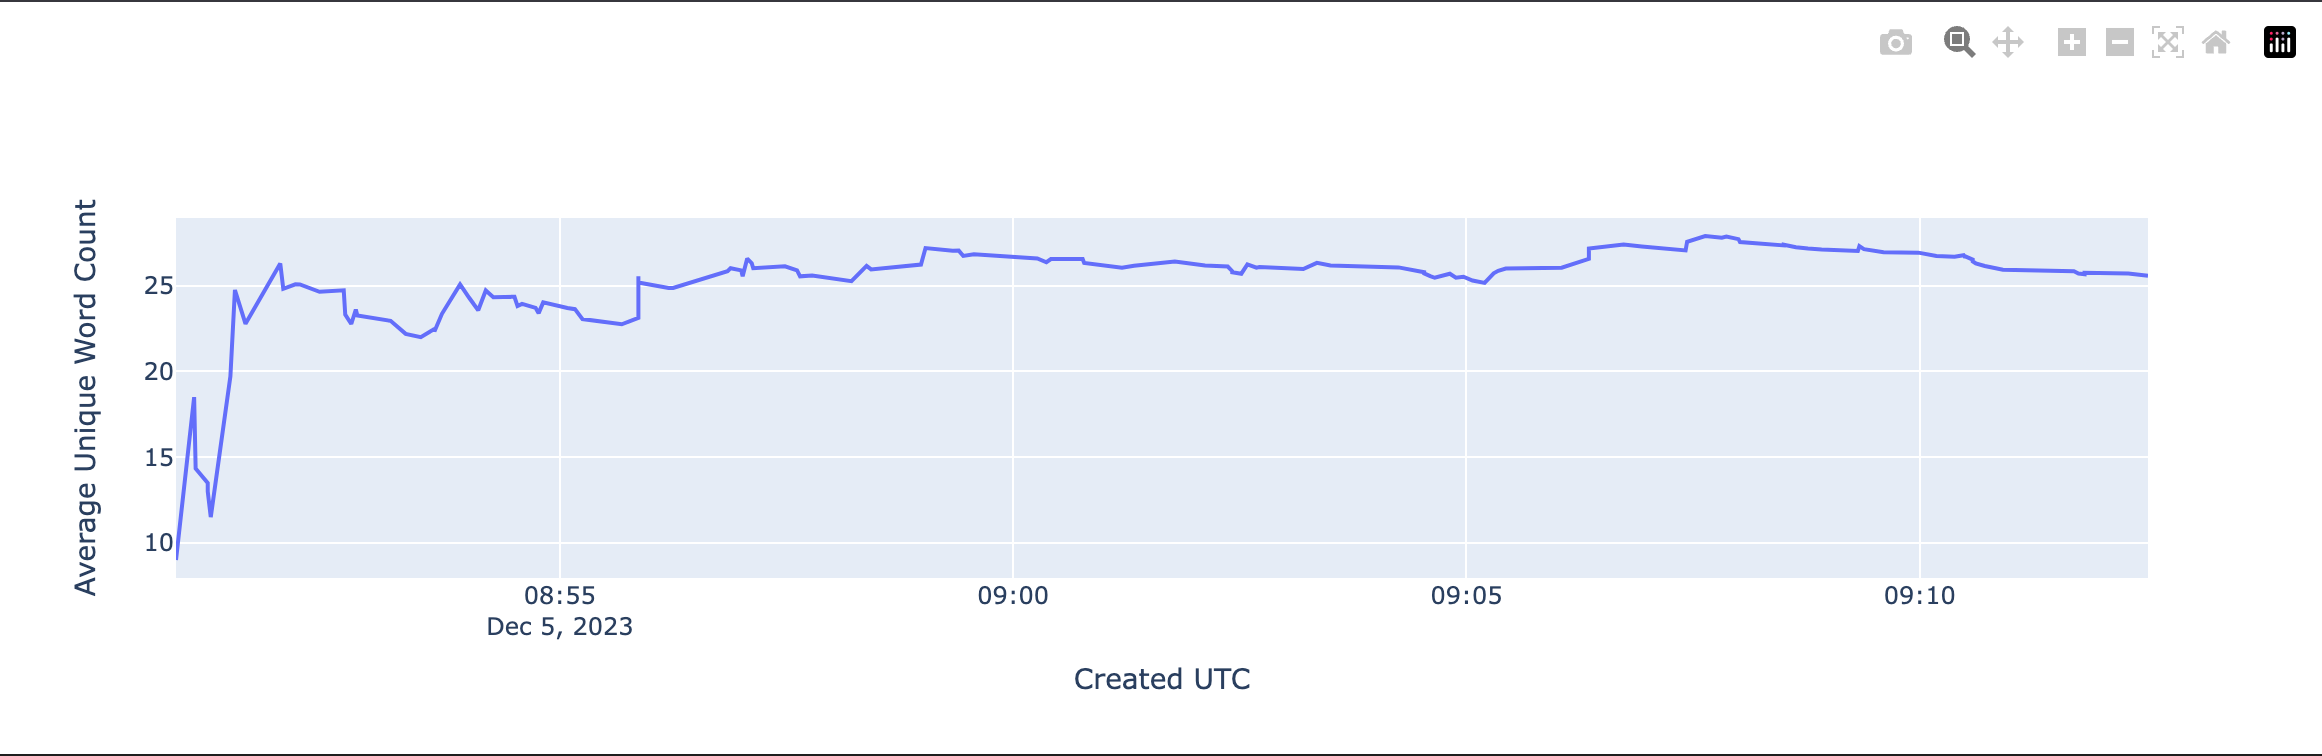

In [11]:
# here is an example of what the function above will plot
from IPython.display import Image
Image(filename='average_unique_plot.png')

#### Cumulative number of unique words in the comments for both subreddits

In [12]:
# function that creates the plot that runs for a specific time period
def cumulative_uniq_words_plot(duration):
    try:
        if not accumulated_df.empty:

            # create plotly lines for each subreddit
            fig = px.line(accumulated_df, x='created_utc', y='cumulative_unique_word_count', color='subreddit', markers=True)

            # intialize plotly figure widget
            fig_widget = go.FigureWidget(fig)

            # calculate start time and end time 
            start_time = time.time()
            end_time = start_time + duration
            fig_widget.update_layout(
                xaxis_title='Created UTC',  
                yaxis_title='Cumulative Unique Word Count'  
            )
            display(fig_widget)

            # while still within the duration
            while time.time() < end_time:
                # create the trace/line for each subreddit where the x axis is the created utc and the y axis is the cumulative number of unique words 
                for trace, subreddit in zip(fig_widget.data, accumulated_df['subreddit'].unique()):
                    df_sub = accumulated_df[accumulated_df['subreddit'] == subreddit]
                    trace.x = df_sub['created_utc']
                    trace.y = df_sub['cumulative_unique_word_count']
                

    # if the plot is interupted, gracefully stop
    except KeyboardInterrupt:
            print("Plotting interrupted.")


In [13]:
# plot the cumulative number of unique words in the comments for both subreddits with duration of 10000 seconds; interupt cell if you want to stop the plot earlier
cumulative_uniq_words_plot(10000)

FigureWidget({
    'data': [{'hovertemplate': ('subreddit=AskAnAmerican<br>cre' ... 'word_count=%{y}<extra></extra>'),
              'legendgroup': 'AskAnAmerican',
              'line': {'color': '#636efa', 'dash': 'solid'},
              'marker': {'symbol': 'circle'},
              'mode': 'markers+lines',
              'name': 'AskAnAmerican',
              'orientation': 'v',
              'showlegend': True,
              'type': 'scatter',
              'uid': '2a1009a1-a910-4618-8bc1-9586972dbea1',
              'x': array(['2023-12-05T09:44:20', '2023-12-05T09:47:19', '2023-12-05T09:49:43',
                          '2023-12-05T09:50:57', '2023-12-05T09:51:40', '2023-12-05T09:51:54',
                          '2023-12-05T09:56:09', '2023-12-05T09:56:46', '2023-12-05T09:58:36'],
                         dtype=object),
              'xaxis': 'x',
              'y': array([9, 382, 518, 588, 702, 705, 1006, 1058, 1192], dtype=object),
              'yaxis': 'y'},
             {'ho

Plotting interrupted.


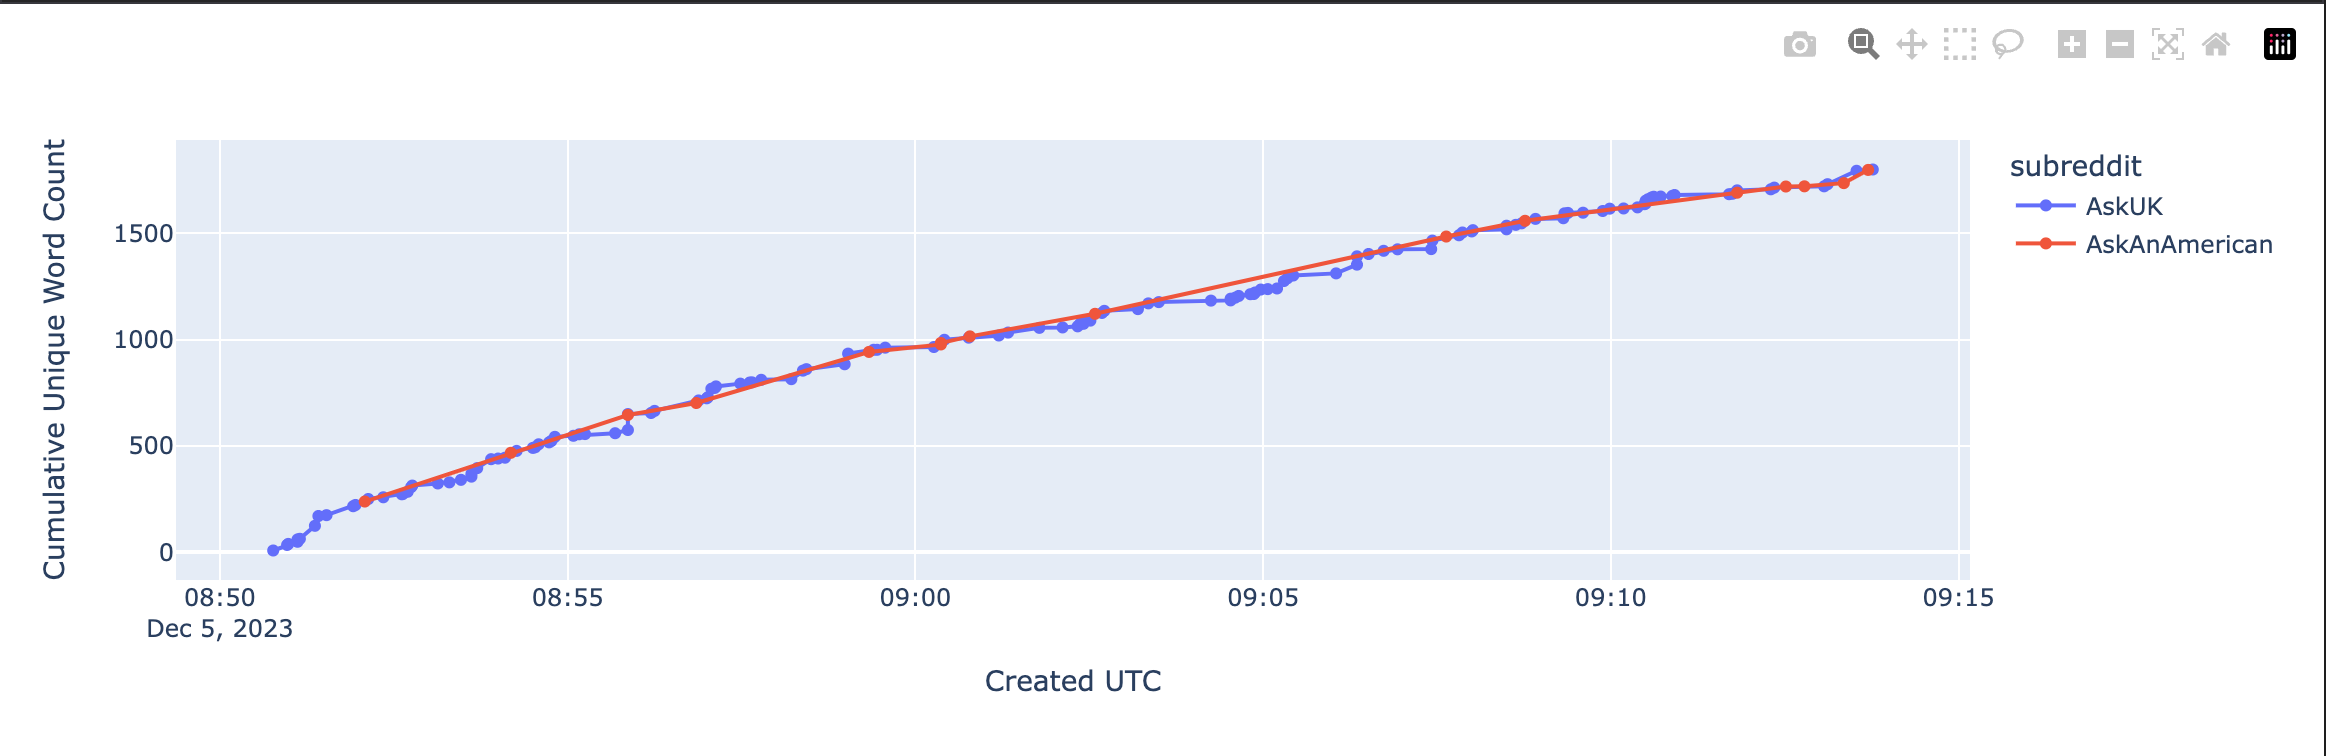

In [14]:
# here is an example of what the function above will plot
from IPython.display import Image
Image(filename='cumulative_unique_plot.png')

It appears the number of unique words used between the two subreddits are not very different. I imagine that a potential reason for this is that the audience within those subreddits are not entirely different. Therefore, the word choice and vocab used isn't going be entirely different. 

#### River regression model to estimate the number of unique words in a comment given the length of the comment

In [15]:
from river import preprocessing
from river import linear_model
from river import metrics
from river import stream
from river import compose

# calculate the length of each comment
accumulated_df['comment_length'] = accumulated_df['body'].apply(lambda text: len(text.split()))

# split data into feature (comment length) and target (unique word count)
X = accumulated_df[['comment_length']].astype(int)
y = accumulated_df['unique_word_count'].astype(int)



In [16]:
# pipeline: StandardScaler and Linear Regression
model = compose.Pipeline(
    preprocessing.StandardScaler(),
    linear_model.LinearRegression()
)

# metric: Root Mean Squared Error
metric = metrics.RMSE()

RMSE: 16.41416


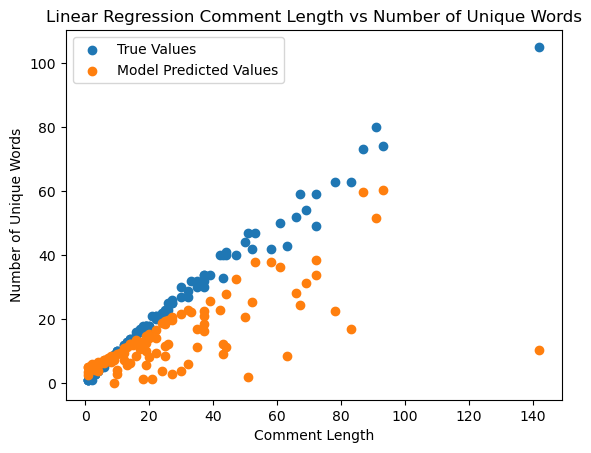

In [17]:
# to store values for plotting
comment_lengths = []
true_values = []
predicted_values = []

# iterate through values in pandas dataframe
for xi, yi in stream.iter_pandas(X, y):
    # append comment lengths 
    comment_lengths.append(xi.get('comment_length'))

    # train model 
    model.learn_one(xi, yi)

    # make predicition 
    y_pred = model.predict_one(xi)

    # append the true value
    true_values.append(yi)

    # append the model's prediction
    predicted_values.append(y_pred)

    # update the metrix
    metric.update(yi, y_pred)

print(metric)

# plot scatter of true values and predicitions from model 
plt.scatter(comment_lengths, true_values, label='True Values')
plt.scatter(comment_lengths, predicted_values, label='Model Predicted Values')
plt.title('Linear Regression Comment Length vs Number of Unique Words')
plt.xlabel('Comment Length')
plt.ylabel('Number of Unique Words')
plt.legend()
plt.show()